In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
import seaborn as sns

logdust_func = open("logdust_3d_func_new.pkl", "rb")
logstdA_func = open("logstdA_func_new.pkl", "rb")
logdust = pickle.load(logdust_func)
logstdA = pickle.load(logstdA_func)

2022-11-21 11:08:49.463597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 11:08:50.087403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 11:08:50.087440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 11:08:50.190927: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 11:08:51.455934: W tensorflow/stream_executor/platform/de

D


2022-11-21 11:08:56.581351: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-21 11:08:56.581404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ava-ThinkPad-X390): /proc/driver/nvidia/version does not exist
2022-11-21 11:08:56.582744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ava/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, p

In [2]:
# rcParams.update({'xtick.major.pad': '7.0'})
# rcParams.update({'xtick.major.size': '7.5'})
# rcParams.update({'xtick.major.width': '1.5'})
# rcParams.update({'xtick.minor.pad': '7.0'})
# rcParams.update({'xtick.minor.size': '3.5'})
# rcParams.update({'xtick.minor.width': '1.0'})
# rcParams.update({'ytick.major.pad': '7.0'})
# rcParams.update({'ytick.major.size': '7.5'})
# rcParams.update({'ytick.major.width': '1.5'})
# rcParams.update({'ytick.minor.pad': '7.0'})
# rcParams.update({'ytick.minor.size': '3.5'})
# rcParams.update({'ytick.minor.width': '1.0'})
# rcParams.update({'axes.titlepad': '15.0'})
# rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [58]:
samp_size = 5

def get_NN_pred_mean(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_mean2(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_std(model_A, model_std, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred_mean = model_A(X_data_flattened, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_mean = (pred_mean.numpy() - 0.111) * 1/1.22

    # UGLY not best way to do this but np.append didn't work
    inp = []
    for i,x in enumerate(X_data_flattened):
      single_inp = [xa for xa in x] + list(pred_mean[i])
      inp.append(single_inp)
    
    inp = np.asarray(inp)
    print(inp.shape)
    pred_std = model_std(np.asarray(inp), training=False)
    pred_std = tf.reshape(pred_std, pred_std.shape[0])
    # pred_np = pred_np.reshape([len(X_data), SAMPLE_SIZE])
    return pred_std

def cart2spherical(x, y, z):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r) # [0, PI]
    phi = np.arctan2(y, x);     # [-PI, PI]
    return [r, theta, phi]
    
    if (x > 0):
        phi = np.arctan(y/x)
    elif (x < 0):
        phi = np.arctan(y/x) + np.pi 
    else:
        phi = np.pi / 2
    return [r, theta, phi] 

def spherical2cart(r, theta, phi):
    '''Return cartesian coordinate from polar coordinate'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

In [4]:
# load each model
modelA_mean = tf.keras.models.load_model('models/modelA/modelA_mean')
modelB_mean = tf.keras.models.load_model('models/modelB/modelB_mean')
modelC_mean = tf.keras.models.load_model('models/modelC/modelC_mean')
modelD_mean = tf.keras.models.load_model('models/modelD/modelD_mean')
modelD_std = tf.keras.models.load_model('models/modelD/modelD_std')

In [5]:
data = np.load('datasets/dust_sim_final_new.npz', allow_pickle=True)
Xo_train, Xo_valid, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
Yo_train, Yo_valid, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']
X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

# used to test
test_data = Xo_test[:,0]

In [6]:
# TODO: this is inconsistent - just loop through X_test values not the whole Xgrid
intrinsic = [np.exp(logdust(x,y,z)) for x,y,z in test_data]
intrinsic_std = [np.exp(logstdA(x,y,z)) for x,y,z in test_data]

def get_underlying_dust(model_mean, X):
    # getting rho
    dA_dx, dA_dy, dA_dz = [], [], []
    norm = model_mean.get_layer('norm')
    dense_1 = model_mean.get_layer('dense_1')
    dense_2 = model_mean.get_layer('dense_2')
    dense_3 = model_mean.get_layer('dense_3')
    pred = model_mean.get_layer('predictions')

    for x,y,z in X:
        xyz = tf.constant([x, y, z])
        with tf.GradientTape() as g:
            g.watch(xyz)
            Y = pred(dense_3(dense_2(dense_1(norm(tf.convert_to_tensor([xyz]))))))
        dA_dxyz = g.gradient(Y, xyz)
        dA_dx.append(dA_dxyz[0])
        dA_dy.append(dA_dxyz[1])
        dA_dz.append(dA_dxyz[2])

    r = np.sqrt(np.square(X[:, 0]) + np.square(X[:, 1]) + np.square(X[:, 2]))
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    x_over_r = np.divide(x, r)
    y_over_r = np.divide(y, r)
    z_over_r = np.divide(z, r)
    dA_dr = np.multiply(dA_dx, x_over_r) + np.multiply(dA_dy, y_over_r) + np.multiply(dA_dz, z_over_r)
    return dA_dr

In [7]:
pred_A_modelA = modelA_mean(test_data)
dA_dr_modelA = get_underlying_dust(modelA_mean, test_data)

In [8]:
pred_A_modelB = modelB_mean(test_data)
dA_dr_modelB = get_underlying_dust(modelB_mean, test_data)

In [9]:
pred_A_modelC = modelC_mean(test_data)
dA_dr_modelC = get_underlying_dust(modelC_mean, test_data)

In [10]:
pred_A_modelD = modelD_mean(test_data)
dA_dr_modelD = get_underlying_dust(modelD_mean, test_data)

In [11]:
pred_mean = get_NN_pred_mean(modelD_mean, test_data)
pred_mean = np.reshape(pred_mean, (pred_mean.shape[0], 1))
model_std_inps = np.append(test_data, pred_mean, axis=1)
constant_log_std = np.log(0.13410718414757786)

pred_std_modelD = get_std_model_pred(modelD_std, model_std_inps, constant_log_std, training=False)
pred_std_modelD = np.reshape(pred_std_modelD, np.shape(pred_std_modelD)[0])
pred_std_modelD = np.exp(pred_std_modelD)

In [12]:
# some reshaping 
num_data = X_test[:,0].shape[0]
pred_A_modelA = np.reshape(pred_A_modelA, num_data)
pred_A_modelB = np.reshape(pred_A_modelB, num_data)
pred_A_modelC = np.reshape(pred_A_modelC, num_data)
pred_A_modelD = np.reshape(pred_A_modelD, num_data)
pred_std_modelD = np.reshape(pred_std_modelD, pred_std_modelD.shape[0])
modelC_final_variable_std = 0.1125117878530318
modelC_final_variable_std_repeated = np.array([modelC_final_variable_std] * num_data)
point2_repeated = np.array([0.2] * num_data)

In [134]:
delta_r = 0.001
delta_r_val = delta_r
ngrid, edge = 21, 2.5
max_r = edge * 2
min_points=10 # min points to along LOS to star to calculate A
std_inflate_rate=1

In [62]:
print(Yo_test.shape)

(2000, 5)


### Get samples along three LOS
- one towards region with high dust density
- one towards region with low dust density
- one towards region with large sigma

In [15]:
# get underlying true dust for LOS 1,2,3
# first calculate the positions of all the samples along LOS which are INSIDE the box and valid
def get_valid_los_samps(i):
    '''
    i: index of X_test position for the LOS
    return a list of X positions along the LOS that are inside the box in euclidean coords!!
    also return star_i which is the index of a star along LOS in the list of X positions of LOS samples
    '''
    star_i = 0
    x, y, z = X_test[i]
    r_star, theta, phi = cart2spherical(x,y,z)
    los_pos_r = []
    i = 0
    for r_prime in np.arange(0, max_r, delta_r):
        pos_prime = spherical2cart(r_prime, theta, phi) # NEW: just to know if point lies outside of the box
        x_prime, y_prime, z_prime = pos_prime
        if (x_prime > edge or x_prime < -edge or y_prime > edge or y_prime < -edge or z_prime > edge or z_prime < -edge):
            break # if outside the edge of box stop taking samples
        los_pos_r.append(pos_prime)
        if (r_prime < r_star):
            star_i = i
        i+=1
    return np.array(los_pos_r), star_i

# for now picking these
i1, i2, i3 = 2, 55, 101
samps_los1, star_los1_i=get_valid_los_samps(i1)
samps_los2, star_los2_i=get_valid_los_samps(i2)
samps_los3, star_los3_i=get_valid_los_samps(i3)
print(samps_los1.shape, samps_los2.shape, samps_los3.shape)

(2717, 3) (3383, 3) (2556, 3)


### Calculate A along the LOS samps found

In [16]:
# get A for all points along LOS 
# these are the true A values across the line of sights chosen
def get_A(x_samps):
    '''
    x_samps: x samples along a LOS in euclidean coords
    returns A for each samp
    '''
    n_samps, _ = x_samps.shape
    A_true = np.zeros(n_samps)  # stores the A values along LOS
    
    # calculate A for each samp
    for i, X in enumerate(x_samps):
        prog=round(i/len(x_samps)*100)
        if (prog % 10 == 0):
            print(str(prog) + ' ', end='')
        
        # ....x
        delta_r = delta_r_val               # set it back to original value

        # each line of sight must have at least n_points along it to calculate the integral to deal with r < delta_r 
        los_samps=x_samps[:i+1] 
        if len(los_samps) < min_points:
            r, theta, phi = cart2spherical(*X)  # samp eucl coord to original
            delta_r = r / min_points
            r_primes = np.linspace(0, r, min_points) 
            # nnew los samps
            los_samps = np.array([spherical2cart(r_prime, theta, phi) for r_prime in r_primes])

        dust = np.array([np.exp(logdust(x, y, z)) for x,y,z in los_samps]) # include the sample
        dust *= np.array([delta_r])
        trueA = np.sum(dust) 
        A_true[i] = trueA
        
    # convert nan values to 0 - only first value of A is for some reason 0
    A_true[np.isnan(A_true)] = 0
    return A_true

A_los1=get_A(samps_los1)
A_los2=get_A(samps_los2)
A_los3=get_A(samps_los3)


0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/tmp/ipykernel_68191/2342302680.py:41: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(z/r)


10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 100 100 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20

In [17]:
# true A of star lying along line of sight
# dumb way of doing it but eh
A_true_star_los1 = get_A(np.array([X_test[i1]]))[0]
A_true_star_los2 = get_A(np.array([X_test[i2]]))[0]
A_true_star_los3 = get_A(np.array([X_test[i3]]))[0]
print(A_true_star_los3)

0 0 0 0.15419641581743745


### Store true std along LOS

In [135]:
def get_std(x_samps):
    n_samps, _ = x_samps.shape
    std_true = np.zeros(n_samps)  # stores the true std values along LOS
    for i, X in enumerate(x_samps):
        std_true[i] = np.exp(logstdA(*X))
    return std_true
        
# note: los samples are in euclidean coordiantes
std_true_los1=get_std(samps_los1) * std_inflate_rate
std_true_los2=get_std(samps_los2) * std_inflate_rate
std_true_los3=get_std(samps_los3) * std_inflate_rate

### Get stars in angular circle

In [163]:
def get_stars_in_angular_circle(star_i, angular_dist, Xs):
    '''return the indecies of all stars within angular dist away
    angular circle: (theta_ctr - theta)^2 + (phi_ctr - phi)^2 < angular_dist^2
    '''
    n_stars, _ = Xs.shape
    r, theta_ctr, phi_ctr = cart2spherical(*X_test[star_i]) # get the actual star which is coming from X_test
    stellar_samps_inds = []
    for i in range(n_stars):
        r_prime, theta_prime, phi_prime = cart2spherical(*Xs[i])

        # (theta_ctr - theta)^2 + (phi_ctr - phi)^2 < 0.15^2
        if ((theta_prime - theta_ctr) ** 2 + (phi_prime - phi_ctr) ** 2 <= angular_dist ** 2):
            stellar_samps_inds.append(i)

    stellar_samps_inds = np.array(stellar_samps_inds)
    return stellar_samps_inds[stellar_samps_inds != star_i] # disclude current star

# get the indecies of all close stars
ang_dist = .10
stellar_samps_i1_train, stellar_samps_i1_valid, stellar_samps_i1_test = get_stars_in_angular_circle(i1, ang_dist, X_train), \
                                                                        get_stars_in_angular_circle(i1, ang_dist, X_valid), \
                                                                        get_stars_in_angular_circle(i1, ang_dist, X_test)
stellar_samps_i2_train, stellar_samps_i2_valid, stellar_samps_i2_test = get_stars_in_angular_circle(i2, ang_dist, X_train), \
                                                                        get_stars_in_angular_circle(i2, ang_dist, X_valid), \
                                                                        get_stars_in_angular_circle(i2, ang_dist, X_test)
stellar_samps_i3_train, stellar_samps_i3_valid, stellar_samps_i3_test = get_stars_in_angular_circle(i3, ang_dist, X_train), \
                                                                        get_stars_in_angular_circle(i3, ang_dist, X_valid), \
                                                                        get_stars_in_angular_circle(i3, ang_dist, X_test)      
print(stellar_samps_i1_train, stellar_samps_i1_valid, stellar_samps_i1_test)
print(stellar_samps_i2_train, stellar_samps_i2_valid, stellar_samps_i2_test)
print(stellar_samps_i3_train, stellar_samps_i3_valid, stellar_samps_i3_test)

# get theta and phi of all stars
# accumulate all stars within X radians 

# print(get_stars_in_angular_circle(i1, 0.3))
# min_theta, min_phi = np.Inf, np.Inf
# max_theta, max_phi = -np.Inf, -np.Inf
# for x in X_test:
#     r, theta, phi = cart2spherical(*x)
#     min_theta = theta if theta < min_theta else min_theta
#     min_phi = phi if phi < min_phi else min_phi
#     max_theta = theta if theta > max_theta else max_theta
#     max_phi = phi if phi > max_phi else max_phi

# print(min_theta, max_theta) # [0 to PI]
# print(min_phi, max_phi)     # [-PI, PI] => range 2PI

[  73  245  334  355 1391 1485 2140 2713 3603 5480] [ 646 1221] [  91  322  360  907 1017 1045 1685]
[  77 2857 3348 3444 3667 3965 4694 5300] [ 583  974 1011] []
[ 259  612 1397 1968 2102 2121 2390 2436 2524 3508 3557 3715 3732 3831
 5723] [ 177  726  836 1092 1873] [ 246  980 1050 1274]


In [78]:
print(std_true_los1.shape, std_true_los1[0], std_true_los1[1])
print(samps_los1.shape)

(2717,) 0.33323127281482734 0.33319737033974317
(2717, 3)


### Plotting

In [161]:
def pred_along_los(subplot_i, i, samps, true_A, star_i, true_std, modelA, modeltype, 
                   modelstd=None, constantstd=None, 
                   pred_color='#8f0000',
                   y_label=None, y_lim=[-1, 7.5]):
    '''los: r, theta, phi
    true_A_of_star A of star lying on LOS
    i: index of X_test position for the LOS - same index as star on the LOS 
    star_i is the index of the star within the LOS positions
    close_stars_inds are the indecies of stars that are closeby to star_i in X_test
    '''
    
    # plotting the true dust
    n_samps, _ = samps.shape
    x, y, z = X_test[i]
    
    # get the rs of samps
    rs_los=[]
    for samp in samps:
        r, _, _ = cart2spherical(*samp)
        rs_los.append(r)
    
    # los_pos = np.asarray(los_pos)
    # X_data_flattened = los_pos.reshape([len(los_pos), 3])
    # pred = modelA(X_data_flattened, training=False).numpy().reshape([len(los_pos)]) # (len(X_data) * SAMPLE_SIZE, 3)
    pred = modelA(samps, training=False)

    if modeltype == 'D':
        # pred_A_reshaped = pred.reshape([n_samps, 1])
        # model_std_inps = np.append(X_data_flattened, pred_A_reshaped, axis=1)
        model_std_inps = np.append(samps, pred, axis=1)
        pred_std = get_std_model_pred(modelstd, model_std_inps, np.log(modelC_final_variable_std), training=False) # TODO: don't forget to get the correct value
        # NOTE: model D returns the log std values, multiply them by np.log(0.12374137631361162) then take the exp
        pred_std = np.reshape(pred_std, np.shape(pred_std)[0])
        pred_std = np.exp(pred_std) * std_inflate_rate
    else:
        pred_std = constantstd
    
    pred = np.reshape(pred, (np.shape(pred)[0]))

    ax = plt.subplot(4, 3, subplot_i)
    # dont draw sigma for baseline model
    
    # predicted and true A
    ax.plot(rs_los, pred, color=pred_color, linestyle='-', linewidth = 0.1, marker = 'o', ms = 1, markeredgewidth=0.2)
    ax.plot(rs_los, true_A, color='grey', linestyle='-', linewidth = 0.1, marker = 'o', ms = 1, markeredgewidth=0.2)
    
    if (modeltype != 'A'):
        ax.fill_between(rs_los, np.array(pred) - pred_std, np.array(pred) + pred_std, color=pred_color, alpha=0.4)
    ax.fill_between(rs_los, true_A - true_std, true_A + true_std, color='grey', alpha=0.4)
    

    # 5 sample of X and their predictions
    rs = [cart2spherical(*x)[0] for x in Xo_test[i]]
    ys = Yo_test[i]
    # ax.plot(rs_los[star_i], true_A[star_i], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="#674747") 
    ax.scatter(rs, ys, marker="o", c='black', s=10, zorder=20, edgecolors='black', linewidths=.5) 
    
    
    # stellar samples along close sightlines
    stellar_samp_train = stellar_samps_i1_train if i==i1 else (stellar_samps_i2_train if i==i2 else stellar_samps_i3_train)
    stellar_samp_valid = stellar_samps_i1_valid if i==i1 else (stellar_samps_i2_valid if i==i2 else stellar_samps_i3_valid)
    stellar_samp_test = stellar_samps_i1_test if i==i1 else (stellar_samps_i2_test if i==i2 else stellar_samps_i3_test)
    for close_star_i in stellar_samp_train:
        rs = [cart2spherical(*x)[0] for x in Xo_train[close_star_i]] # go thorugh the samples of each close star
        ys = Yo_train[close_star_i]
        ax.scatter(rs, ys, marker=".", c='grey', s=10, zorder=10, edgecolors='black', linewidths=.3) 
        # draw line from mean of samples to samples
        rs_avg, ys_avg = np.average(rs), np.average(ys)
        for r, y in zip(rs, ys):
            ax.plot([r, rs_avg], [y, ys_avg], color='grey', alpha=.4)
        
    for close_star_i in stellar_samp_valid:
        rs = [cart2spherical(*x)[0] for x in Xo_valid[close_star_i]] 
        ys = Yo_valid[close_star_i]
        ax.scatter(rs, ys, marker=".", c=pred_color, s=10, zorder=10, edgecolors='black', linewidths=.3) 
        # draw line from mean of samples to samples
        rs_avg, ys_avg = np.average(rs), np.average(ys)
        for r, y in zip(rs, ys):
            ax.plot([r, rs_avg], [y, ys_avg], color=pred_color, alpha=.4)
        
    for close_star_i in stellar_samp_test:
        rs = [cart2spherical(*x)[0] for x in Xo_test[close_star_i]] 
        ys = Yo_test[close_star_i]
        ax.scatter(rs, ys, marker=".", c=pred_color, s=10, zorder=10, edgecolors='black', linewidths=.3) 
        # draw line from mean of samples to samples
        rs_avg, ys_avg = np.average(rs), np.average(ys)
        for r, y in zip(rs, ys):
            ax.plot([r, rs_avg], [y, ys_avg], color=pred_color, alpha=.4)
        
    
    # plt.axvline(x = valid_r, color='black') # new: not plotting black line
    # plt.xlim([0, max_r])
    ax.set_ylim(y_lim[0], y_lim[1])
    
    ax.set_xlim(0, rs_los[-1])

    if subplot_i <= 3: # for first three plots add los title
        title = str(np.around(x / r, 2)) + 'i + ' + str(np.around(y/r, 2)) + 'j + ' + str(np.around(z/r, 2)) + ' k'
        plt.title(r'${0}$'.format(title), y=1.1)
    
    if y_label != None:
        plt.ylabel(y_label, rotation='horizontal', labelpad=50)

So I think for a sketch we actually don't have to do a ton of modifications to your initial version. I think pretty much we want:
- DONE 4 rows (one for each model ABCD)
- DONE WIP 3 columns (for 3 different LOS; one towards region with high dust density, one towards region with low dust density, one towards region with large sigma)
- DONE For each subplot, we'll want to show the true A and sigma values for the LOS profile (so this will be the same for each column)
- For each subplot, we'll want to show the predictions from our model for A and sigma [if available] (same colours as your previous residual plots).

/tmp/ipykernel_68191/177112395.py:41: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(z/r) # [0, PI]


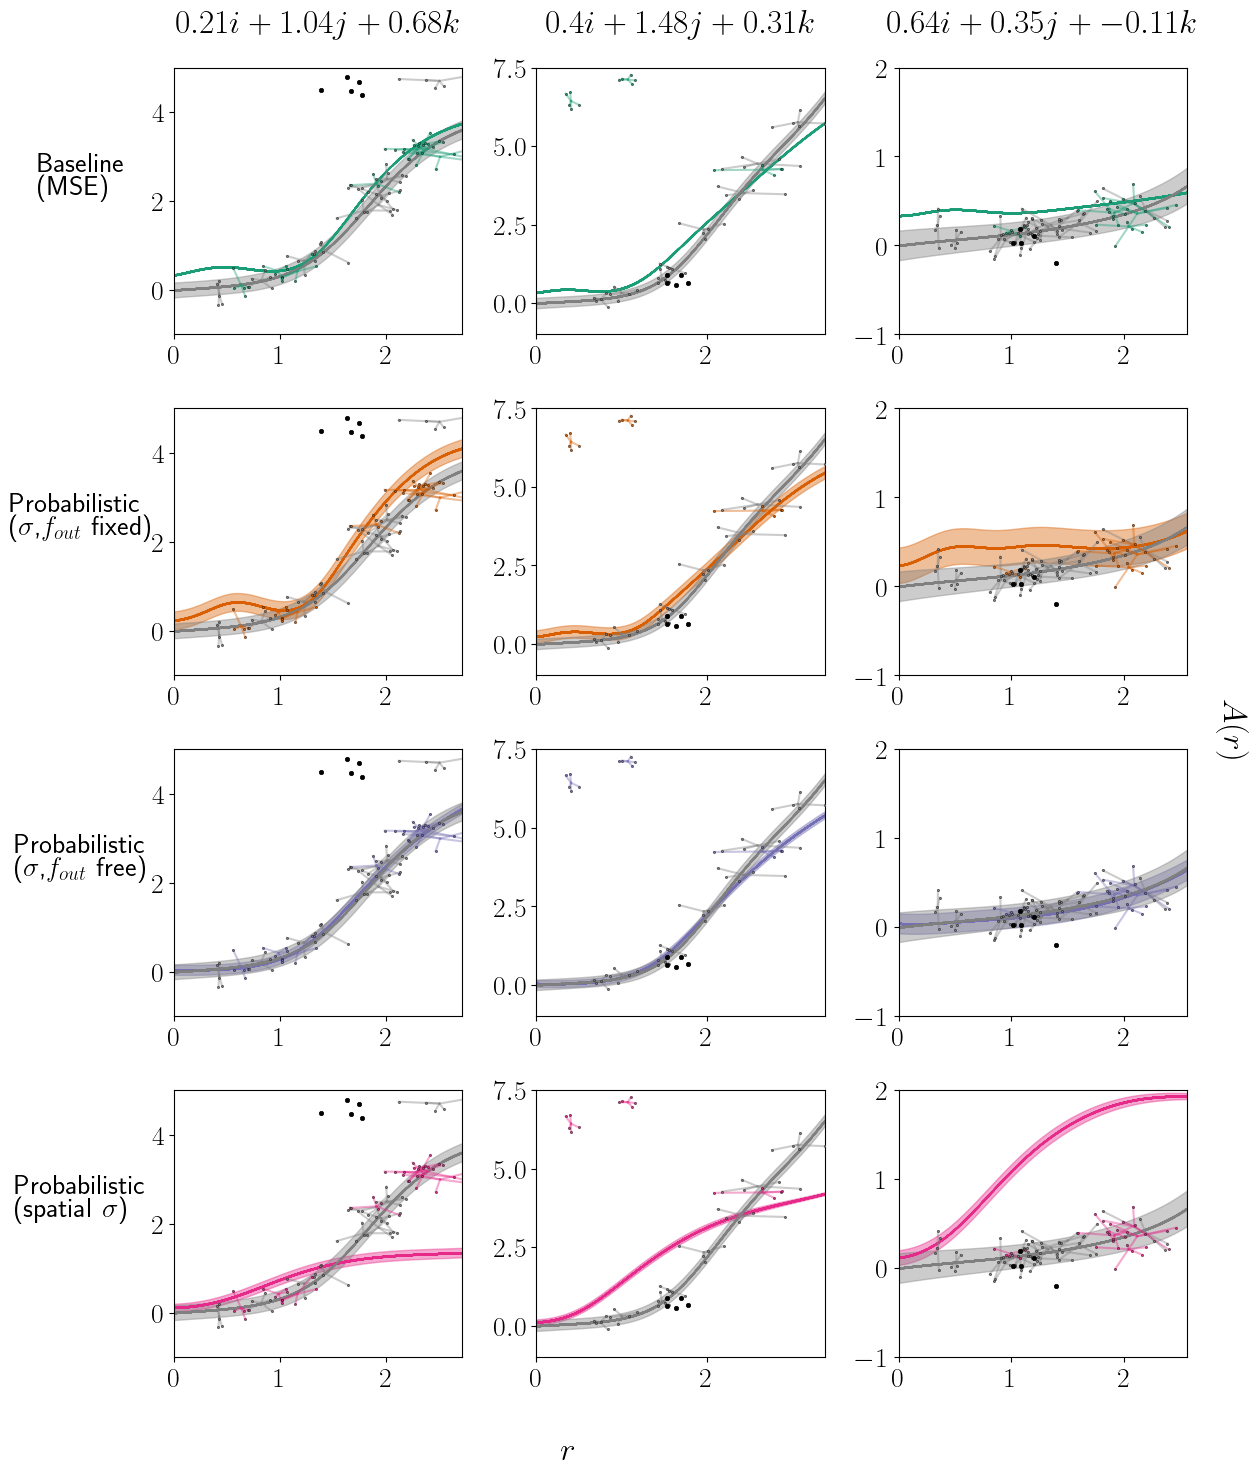

In [164]:
fig = plt.figure(figsize=(13, 15), tight_layout=True)
lims, std_lims = [-1, 10], [0, 0.4] # TODO change this so the range is right
color1, color2, color3, color4 = "#1b9e77", "#d95f02", "#7570b3", "#e7298a" 
fig.supxlabel(r'$r$')
fig.supylabel(r'$A(r)$', ha="right", x=1.025, rotation=270)
y_lim_center_i1 = [-1, 5.]
y_lim_center_i3 = [-1, 2.]
# plt.ylim([0, 7.5])

# NOTE: close stars means stars in a small angular circle surrounding the target star

# model A
# TODO: for later change this trueA_los1
pred_along_los(1, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelA_mean, 'A',
               pred_color=color1, y_label="Baseline\n(MSE)", 
               y_lim=y_lim_center_i1)
pred_along_los(2, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelA_mean, 'A',
               pred_color=color1)
pred_along_los(3, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelA_mean, 'A', 
               pred_color=color1, y_lim=y_lim_center_i3)

# model B
pred_along_los(4, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelB_mean, 'B',
               constantstd=0.2 * std_inflate_rate, pred_color=color2, y_label="Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" fixed)",
               y_lim=y_lim_center_i1)
pred_along_los(5, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelB_mean, 'B',
               constantstd=0.2 * std_inflate_rate, pred_color=color2)
pred_along_los(6, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelB_mean, 'B',
               constantstd=0.2 * std_inflate_rate, pred_color=color2, y_lim=y_lim_center_i3)

# model C
pred_along_los(7, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelC_mean, 'C',
               constantstd=modelC_final_variable_std * std_inflate_rate, pred_color=color3, y_label="Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" free)",
               y_lim=y_lim_center_i1)
pred_along_los(8, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelC_mean, 'C',
               constantstd=modelC_final_variable_std * std_inflate_rate, pred_color=color3)
pred_along_los(9, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelC_mean, 'C',
               constantstd=modelC_final_variable_std * std_inflate_rate, pred_color=color3,
               y_lim=y_lim_center_i3)

# model D
pred_along_los(10, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelD_mean, 'D',
               modelstd=modelD_std, pred_color=color4, y_label="Probabilistic\n(spatial "+r'$\sigma$'+")",
               y_lim=y_lim_center_i1)
pred_along_los(11, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelD_mean, 'D',
               modelstd=modelD_std, pred_color=color4)
pred_along_los(12, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelD_mean, 'D',
               modelstd=modelD_std, pred_color=color4, y_lim=y_lim_center_i3)

plt.savefig('plots/4panel_los_2.png', bbox_inches='tight')

1. **DONE** For the truth we'll probably want to pick something like a black/gray so it's easy to overplot different colours over it. We'll want to use a black line for the true mean and a grey shaded region for the uncertainty. We can adjust the alpha as needed to get the right transparency.
2. **DONE** overplot stars as black scatter points if we wanted to add them in. We would probably want to show exactly what you have plotted (noisy samples, including outliers). The true values will be useful when (re)computing the residual plots you sent around last time.
3. indicate outliers with a different color
4. **DONE** For the four models, we'll want to instead make the same plots but with a set of colourblind-friendly choices (so solid line for mean, lighter shaded region for uncertainty if available). In the original one you sent around you used a red-brown-green-blue pallette, so we can either keep the same or try something like https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=4 (or other online resources) for inspiration.
5. **DONE** I think the current LOS directions that you picked look pretty reasonable! We'll just want to do it by eye from a 3-D plot, most likely.
6. **DONE** You can probably adjust the x-axis range to not extend beyond the reliable line. (We can keep the y-axis range the same.)
7. Get the scatter colour to agree with the mean colour (so light green+ dark green, etc.) instead of using yellow
8. **DONE** And for the gray we want to plot the true scatter along the LOS, so it should be the same in all the plots (rather than now where it’s just the same as the predicted one)
9. **DONE**And in terms of the padding: yes, you have to get rid of the padding in x and y by manually setting the xlim and ylim

NOTE: that we amplify the scatter by a factor of 5 to better see the effect

1. ... FIGURE out the order of the plots, bring black dots forward
2. **DONE** dont inflate the std values by too much
3. **DONE** samples have r and A values - fix those
4. adjust the y-axis ranges for each column to emphasize the intrinsic scatter more i.e first and third column, adjust the y-axis ranges
5. add more stars in a small angular circle so it looks blobby